# Facial Emotion Recognition (FER) with CNN

## 1. Project Overview
This project implements a deep **Convolutional Neural Network (CNN)** to classify human facial emotions into seven distinct categories (Angry, Disgust, Fear, Happy, Neutral, Sad, Surprise). The model is trained on the **FER-2013** dataset and optimized for real-time inference.

The objective is to demonstrate a complete End-to-End Machine Learning pipeline, from raw data ingestion to a deployed real-time webcam application within a cloud environment.

## 2. Key Technical Learnings
* **Architecture Design:** Implementation of a VGG-style CNN architecture with deeper convolutional blocks, Batch Normalization, and Dropout to combat overfitting on grayscale images.
* **Data Pipeline Engineering:** Handling large-scale image data via `ImageDataGenerator` for on-the-fly augmentation and efficient memory usage.
* **Callback Strategy:** Utilizing dynamic learning rate adjustment (`ReduceLROnPlateau`) and `EarlyStopping` to optimize convergence and training time.
* **Real-Time Engineering:** Developing a custom **JavaScript-to-Python bridge** to enable low-latency, in-browser webcam inference directly within Google Colab, overcoming standard cloud visualization limitations.

---

## 📖 Table of Contents
1. [**Setup & Imports**](#1)
2. [**Data Loading & Preparation**](#2)
3. [**Exploratory Data Analysis (EDA)**](#3)
4. [**Data Preprocessing Pipeline**](#4)
5. [**Model Architecture**](#5)
6. [**Training**](#6)
7. [**Evaluation**](#7)
8. [**Real-Time Deployment**](#8)

---

<a id="1"></a>
## 1. Setup & Imports
We initialize the environment by importing necessary libraries.
* **TensorFlow/Keras:** For building and training the deep learning model.
* **OpenCV & PIL:** For image processing and transformation.
* **Scikit-Learn:** For metrics and data splitting.
* **KaggleHub:** For direct, authenticated dataset downloading.

In [1]:
# --- 1. System & Data Utilities ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import kagglehub

# --- 2. Deep Learning (TensorFlow/Keras) ---
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization, Activation, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- 3. Metrics & Scikit-Learn ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

# --- 4. Computer Vision (OpenCV) & Colab Utils ---
import cv2
import io
import base64
from IPython.display import display, Javascript
from google.colab.output import eval_js
from PIL import Image

# --- Configuration ---
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_style("whitegrid")

# Dataset Parameters
IMG_H, IMG_W = 48, 48
CHANNELS = 1
NUM_CLASSES = 7
CLASS_LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

print(f"Setup Complete. TensorFlow Version: {tf.__version__}")

Setup Complete. TensorFlow Version: 2.19.0


<a id="2"></a>
## 2. Data Loading
We fetch the **FER-2013** dataset directly from Kaggle. The dataset consists of 48x48 pixel grayscale images of faces. The data is stored in a CSV format, requiring parsing of pixel strings into numerical arrays.

In [2]:
# Download dataset
print("Downloading FER-2013 Dataset...")
path = kagglehub.dataset_download('deadskull7/fer2013')
print(f"Data source import complete. Path: {path}")

# Load CSV
csv_path = f"{path}/fer2013.csv"
data = pd.read_csv(csv_path)

# Quick Inspection
print(f"Dataset Shape: {data.shape}")
print("Missing Values:\n", data.isnull().sum())
data.head()

100%|██████████| 96.6M/96.6M [00:00<00:00, 110MB/s]

Extracting files...


Data source import complete. Path: /root/.cache/kagglehub/datasets/deadskull7/fer2013/versions/1
Dataset Shape: (35887, 3)
Missing Values:
 emotion    0
pixels     0
Usage      0
dtype: int64


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


<a id="3"></a>
## 3. Exploratory Data Analysis (EDA)
Analyzing the distribution of the target classes is critical for identifying potential bias. We visualize the frequency of each emotion in the dataset to understand class imbalance.

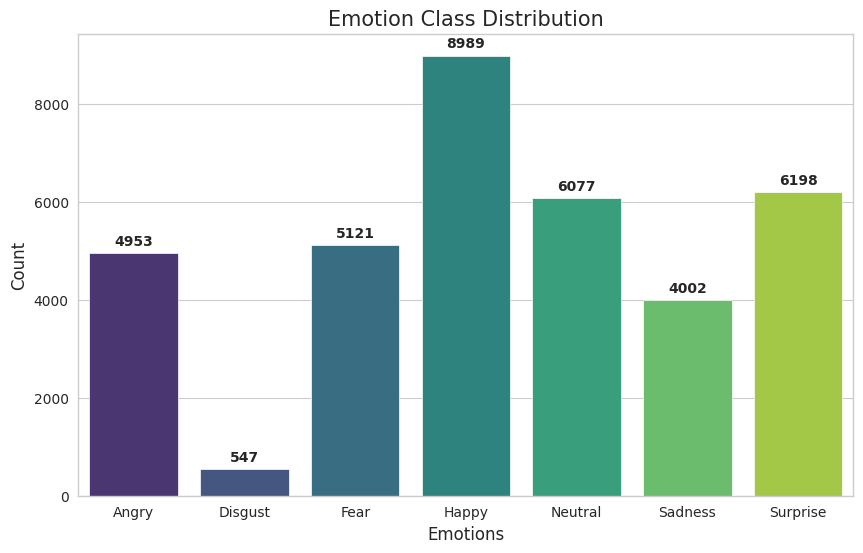

In [3]:
# Count samples per emotion
emotion_counts = data['emotion'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=CLASS_LABELS, y=emotion_counts.values, palette="viridis")
plt.title('Emotion Class Distribution', fontsize=15)
plt.xlabel('Emotions')
plt.ylabel('Count')

# Add Labels
for i, v in enumerate(emotion_counts.values):
    ax.text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')

plt.show()

<a id="4"></a>
## 4. Data Preprocessing Pipeline
To prepare the raw data for the CNN, we perform the following transformations:
1.  **Reshaping:** Converting flat 1D pixel arrays into 3D image tensors `(48, 48, 1)`.
2.  **Normalization:** Scaling pixel intensity values to the range `[0, 1]` to aid gradient descent.
3.  **One-Hot Encoding:** Converting categorical labels into binary class matrices.
4.  **Stratified Splitting:** dividing data into Train (80%), Validation (10%), and Test (10%) sets while preserving class distribution.

Converting pixels to arrays...
Training Data: (28709, 48, 48, 1)
Validation Data: (3589, 48, 48, 1)
Test Data: (3589, 48, 48, 1)


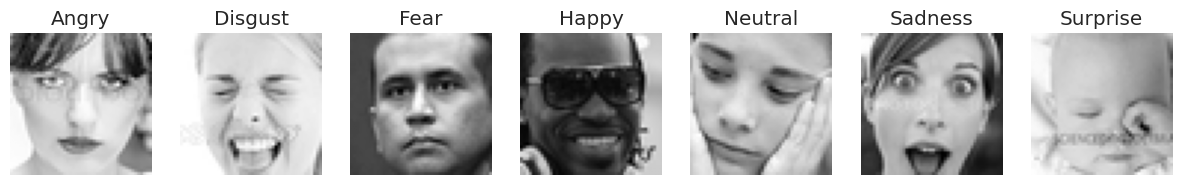

In [4]:
# 1. Convert pixels to array
print("Converting pixels to arrays...")
pixels = data['pixels'].apply(lambda x: np.fromstring(x, sep=' ')).values
pixels = np.vstack(pixels)

# 2. Reshape to (N, 48, 48, 1)
X = pixels.reshape(-1, 48, 48, 1)

# 3. Normalize to [0, 1]
X = X.astype('float32') / 255.0

# 4. One-Hot Encode Labels
y = to_categorical(data['emotion'], num_classes=NUM_CLASSES)

# 5. Split Data
# First Split: Train vs (Test + Val)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Second Split: Test vs Val
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training Data: {X_train.shape}")
print(f"Validation Data: {X_val.shape}")
print(f"Test Data: {X_test.shape}")

# 6. Visualize Sample Images
plt.figure(figsize=(15, 5))
for i in range(7):
    plt.subplot(1, 7, i+1)
    idx = np.where(np.argmax(y_train, axis=1) == i)[0][0] # Find first example of each class
    plt.imshow(X_train[idx].reshape(48, 48), cmap='gray')
    plt.title(CLASS_LABELS[i])
    plt.axis('off')
plt.show()

### 4.1 Data Augmentation
We apply real-time data augmentation to the training set to improve model generalization. Transformations include random rotations, width/height shifts, and shearing. This helps the model become invariant to minor changes in face orientation and position.

In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation generator (No augmentation, just rescaling if needed)
val_datagen = ImageDataGenerator()

# Create Flow Generators
batch_size = 64
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

<a id="5"></a>
## 5. Model Architecture (CNN)
We construct a sequential CNN optimized for feature extraction from low-resolution images.
* **Convolutional Blocks:** Four blocks of `Conv2D` layers with increasing filter sizes (64 -> 512) to capture hierarchical features.
* **Regularization:** `BatchNormalization` is applied to stabilize learning, and `Dropout` is used to prevent overfitting.
* **Activation:** `ELU` (Exponential Linear Unit) is chosen for its ability to handle vanishing gradients better than ReLU in some deep networks.
* **Classifier Head:** Fully connected `Dense` layers leading to a Softmax output for multi-class probability distribution.

In [6]:
def build_cnn_model(input_shape=(48, 48, 1), num_classes=7):
    model = Sequential()

    # --- Block 1 ---
    model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # --- Block 2 ---
    model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # --- Block 3 ---
    model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # --- Block 4 ---
    model.add(Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # --- Classification Head ---
    model.add(Flatten())

    model.add(Dense(256, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_cnn_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 2,736,391 (10.44 MB)

 Trainable params: 2,733,959 (10.43 MB)

 Non-trainable params: 2,432 (9.50 KB)

<a id="6"></a>
## 6. Training Configuration
The model is trained using the **Adam** optimizer. We implement specific callbacks to monitor performance:
* **ModelCheckpoint:** Saves the best weights based on validation accuracy.
* **EarlyStopping:** Halts training if validation loss does not improve for 10 epochs.
* **ReduceLROnPlateau:** Reduces the learning rate by a factor of 0.2 if validation loss stagnates, allowing for fine-grained weight updates.

In [7]:
# Callbacks
checkpoint = ModelCheckpoint(
    'best_emotion_model.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=0.00001
)

# Training
history = model.fit(
    train_generator,
    epochs=40, # Adjusted for demo speed, increase for better results
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

Epoch 1/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2220 - loss: 2.2382
Epoch 1: val_accuracy improved from -inf to 0.33408, saving model to best_emotion_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.2220 - loss: 2.2377 - val_accuracy: 0.3341 - val_loss: 1.6608 - learning_rate: 0.0010
Epoch 2/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3318 - loss: 1.7301
Epoch 2: val_accuracy improved from 0.33408 to 0.36695, saving model to best_emotion_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.3318 - loss: 1.7299 - val_accuracy: 0.3670 - val_loss: 1.6267 - learning_rate: 0.0010
Epoch 3/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3969 - loss: 1.5614
Epoch 3: val_accuracy improved from 0.36695 to 0.46169, saving model to best_emotion_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.3969 - loss: 1.5613 - val_accuracy: 0.4617 - val_loss: 1.4049 - learning_rate: 0.0010
Epoch 4/40
449/449 ━━━

<a id="7"></a>
## 7. Performance Evaluation
We evaluate the model using quantitative metrics and visualizations:
* **Loss & Accuracy Curves:** To diagnose overfitting or underfitting trends.
* **Confusion Matrix:** To analyze misclassification patterns between specific emotions (e.g., confusing "Fear" with "Surprise").
* **Classification Report:** To view Precision, Recall, and F1-Score for each class.

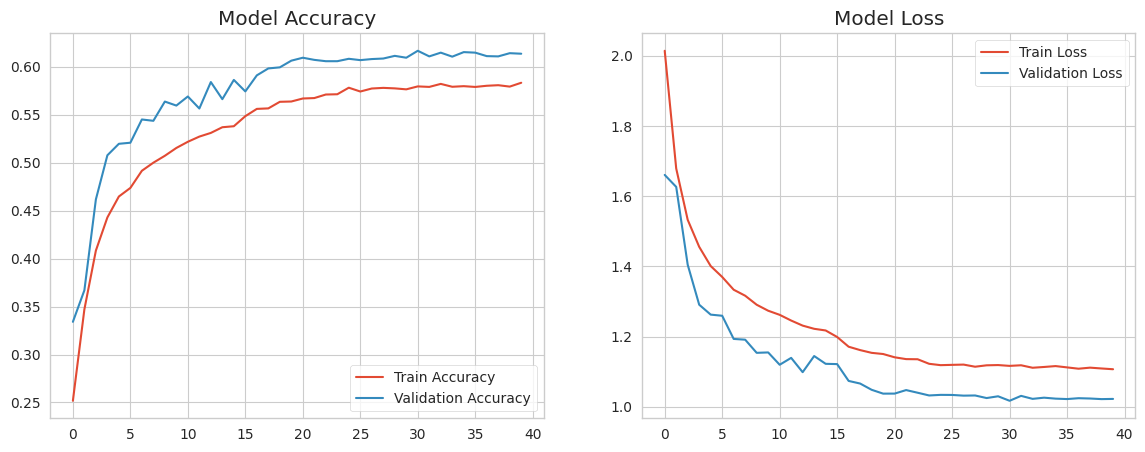

In [8]:
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


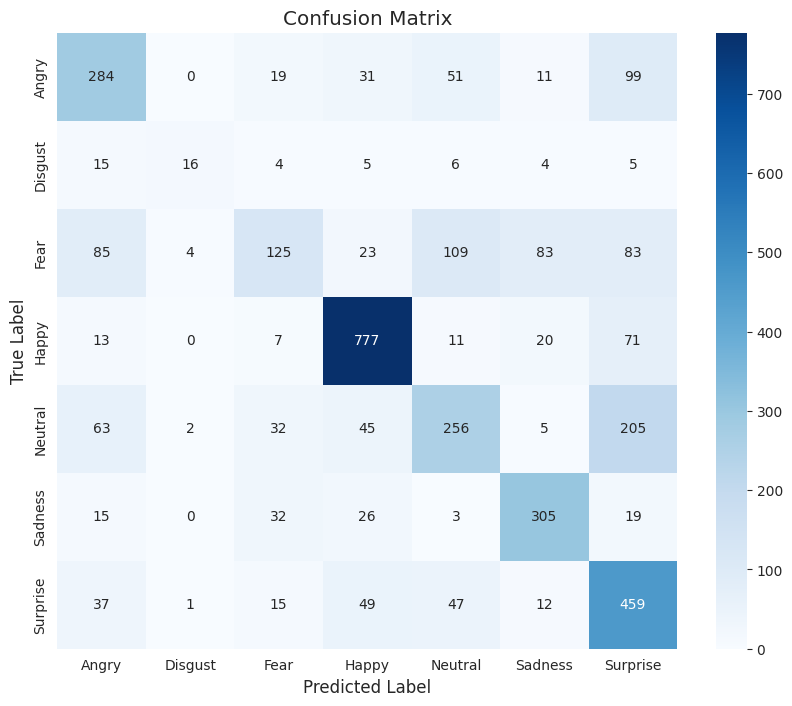


Classification Report:

              precision    recall  f1-score   support

       Angry       0.55      0.57      0.56       495
     Disgust       0.70      0.29      0.41        55
        Fear       0.53      0.24      0.34       512
       Happy       0.81      0.86      0.84       899
     Neutral       0.53      0.42      0.47       608
     Sadness       0.69      0.76      0.73       400
    Surprise       0.49      0.74      0.59       620

    accuracy                           0.62      3589
   macro avg       0.62      0.56      0.56      3589
weighted avg       0.62      0.62      0.60      3589



In [9]:
# Predict on Test Set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate Matrix
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=CLASS_LABELS, columns=CLASS_LABELS)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_LABELS))

<a id="8"></a>
## 8. Real-Time Deployment (Webcam)
Standard Colab notebooks run on a remote server and cannot directly access local hardware. To enable real-time inference, we implement a **JavaScript-Python bridge**.

**Workflow:**
1.  **Frontend (JS):** Captures video frames from the user's browser.
2.  **Communication:** Encodes frames as Base64 strings and sends them to the Python kernel.
3.  **Backend (Python):** Decodes the image, detects faces using Haar Cascades, pre-processes the ROI, and runs inference.
4.  **Feedback:** Returns the annotated frame with bounding boxes and prediction labels to the browser canvas.

In [10]:
# --- JavaScript Definitions ---
def video_stream():
    js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'Initializing...';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = 640;
      video.height = 480;
      video.setAttribute('playsinline', '');

      stream = await navigator.mediaDevices.getUserMedia({video: { facingMode: "user"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      div.appendChild(imgElement);

      const btn = document.createElement('button');
      btn.textContent = "🛑 Stop Video";
      btn.style.backgroundColor = "red";
      btn.style.color = "white";
      btn.style.marginTop = "10px";
      btn.onclick = () => { shutdown = true; };
      div.appendChild(btn);

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640;
      captureCanvas.height = 480;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }

    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')
    display(js)

def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

def js_to_image(js_reply):
    image_bytes = base64.b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

def bbox_to_bytes(bbox_array):
    bbox_PIL = Image.fromarray(bbox_array, 'RGBA')
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format((base64.b64encode(iobuf.getvalue())).decode('ascii'))
    return bbox_bytes

### 8.2 Live Inference Loop
The following loop initializes the camera stream and processes frames continuously until the "Stop" button is clicked.

In [12]:
# Load Face Detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Start Stream
video_stream()
label_html = 'Starting Emotion AI...'
bbox = ''

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Convert JS image to Python
    img = js_to_image(js_reply["img"])
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Detect Faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    for (x, y, w, h) in faces:
        # Draw Box
        bbox_array = cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (0, 255, 0), 2)

        try:
            # ROI Extraction
            roi_gray = gray[y:y+h, x:x+w]
            roi_gray = cv2.resize(roi_gray, (48, 48))

            # Normalize & Reshape
            roi = roi_gray.astype('float32') / 255.0
            roi = np.expand_dims(roi, axis=0) # (1, 48, 48)
            roi = np.expand_dims(roi, axis=-1) # (1, 48, 48, 1)

            # Predict Emotion
            preds = model.predict(roi, verbose=0)
            emotion_idx = np.argmax(preds)
            emotion_label = CLASS_LABELS[emotion_idx]
            confidence = np.max(preds)

            # Display Label
            label_text = f"{emotion_label} ({confidence*100:.1f}%)"
            cv2.putText(bbox_array, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

        except Exception as e:
            print(f"Error: {e}")

    # Convert overlay back to JS
    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

<IPython.core.display.Javascript object>